In [ ]:
import rlcard
from rlcard.agents import RandomAgent
from rlcard.agents.dqn_agent import DQNAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
)
import matplotlib.pyplot as plt
import numpy as np
from rlcard import models

# 1. Setup Environment
NUM_PLAYERS = 4
env = rlcard.make('limit-holdem', config={'num_players': NUM_PLAYERS})

# 2. Initialize the DQN Agent
device = "mps"
dqn_agent = DQNAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[512, 256, 128], # Neural network architecture
    device=device,
    replay_memory_size=100_000,
    batch_size=128,
    update_target_estimator_every=5000,
    replay_memory_init_size=128,
    epsilon_end=0.01,
    epsilon_decay_steps=200_000,
    train_every=4,
    learning_rate=1e-4
)

random_agent = RandomAgent(num_actions=env.num_actions)

# 4. Bind them to the environment
# DQN is Player 0, others follow
agents = [dqn_agent] + [models.load('limit-holdem-rule-v1').agents[0]] * 1
env.set_agents(agents)

# 5. Training Loop
train_episodes = 700_000
evaluate_every = 100

training_losses = []

# 2. Improved Monkey-patch
# We use a wrapper to ensure we capture the loss only when an update actually occurs
original_train = dqn_agent.train

def patched_train():
    loss = original_train()
    if loss is not None:
        # RLCard sometimes returns loss as a scalar or a numpy array; 
        # we convert to float for plotting consistency.
        training_losses.append(float(loss))
    return loss

dqn_agent.train = patched_train

# 3. Training Loop
print("Starting training...")
with Logger('log_path') as logger:
    for episode in range(train_episodes):
        trajectories, payoffs = env.run(is_training=True)
        trajectories = reorganize(trajectories, payoffs)
        
        # The agent.feed() call internally triggers dqn_agent.train()
        for ts in trajectories[0]:
            dqn_agent.feed(ts)

        if episode % evaluate_every == 0:
            reward = tournament(env, 100)[0] # Track DQN's payoff specifically
            print(f"Episode: {episode} | Loss: {training_losses[-1] if training_losses else 'N/A'} | Reward: {reward}")
            logger.log_performance(episode, tournament(env, 100)[0])

# 4. Final Plotting Logic
def plot_loss(losses, window=200):
    if not losses:
        print("No loss data captured. Ensure the agent is training (check buffer size vs batch size).")
        return

    plt.style.use('ggplot') # Cleaner visual style
    plt.figure(figsize=(12, 6))
    
    # Raw Loss
    plt.plot(losses, alpha=0.2, color='royalblue', label='Raw Loss')
    
    # Moving Average (to smooth out the noise typical in DQN)
    if len(losses) > window:
        smooth_loss = np.convolve(losses, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(losses)), smooth_loss, color='darkblue', linewidth=2, label=f'Moving Avg (w={window})')
    
    plt.title('DQN Training Convergence: No-Limit Holdem')
    plt.xlabel('Training Steps (Weight Updates)')
    plt.ylabel('Huber Loss / MSE')
    plt.yscale('log') # Loss can span orders of magnitude; log scale helps visibility
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.tight_layout()
    plt.savefig('dqn_loss_optimized.png')
    plt.show()

plot_loss(training_losses)


Starting training...
Episode: 0 | Loss: N/A | Reward: -0.015

----------------------------------------
  episode      |  0
  reward       |  0.075
----------------------------------------
Episode: 100 | Loss: N/A | Reward: -0.06

----------------------------------------
  episode      |  100
  reward       |  -0.085
----------------------------------------
INFO - Step 128, rl-loss: 4.225728988647461
INFO - Copied model parameters to target network.
INFO - Step 160, rl-loss: 2.1670303344726562Episode: 200 | Loss: 2.1670303344726562 | Reward: 0.17

----------------------------------------
  episode      |  200
  reward       |  0.255
----------------------------------------
INFO - Step 252, rl-loss: 1.9722384214401245Episode: 300 | Loss: 1.9722384214401245 | Reward: -0.23

----------------------------------------
  episode      |  300
  reward       |  0.25
----------------------------------------
INFO - Step 344, rl-loss: 0.8328198790550232Episode: 400 | Loss: 0.8328198790550232 | Rewar

KeyboardInterrupt: 

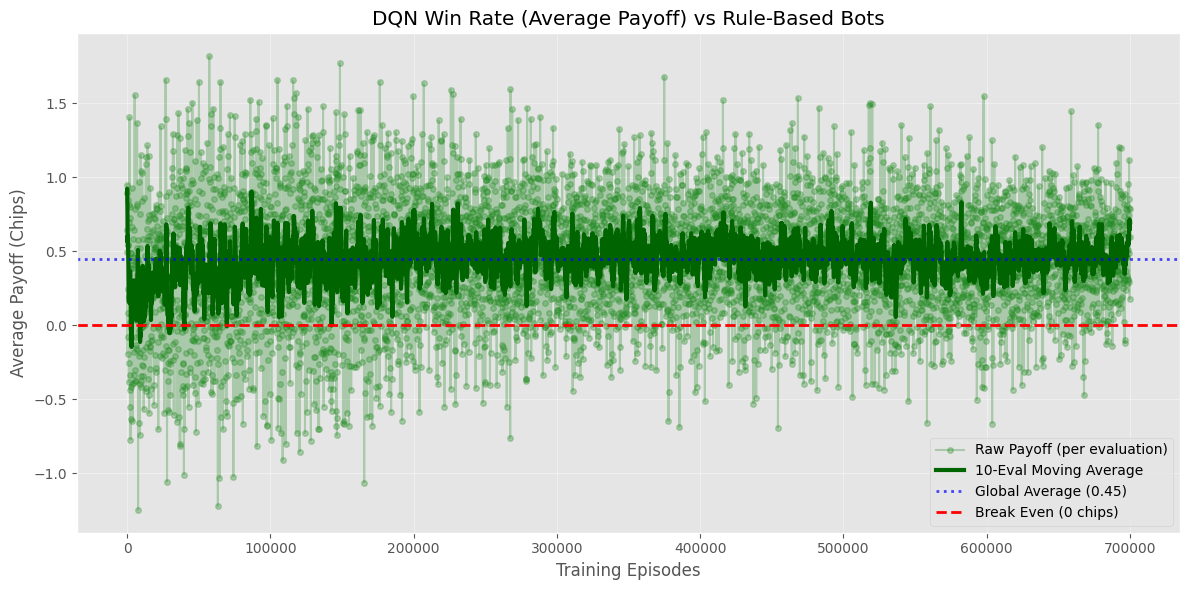

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# The path where RLCard's Logger saved the tournament data
csv_file = 'log_path/performance.csv'

def plot_payoff(csv_path, window_size=10):
    if not os.path.exists(csv_path):
        print(f"File not found: {csv_path}. Make sure the Logger ran successfully.")
        return

    # Read the generated CSV file
    data = pd.read_csv(csv_path)
    
    # RLCard saves two columns: the timestep/episode and the reward
    episodes = data.iloc[:, 0]
    payoffs = data.iloc[:, 1]
    
    # Calculate the rolling average (moving average)
    # min_periods=1 ensures it plots from the very beginning, just using fewer points
    moving_avg = payoffs.rolling(window=window_size, min_periods=1).mean()
    
    # Calculate the global average over the entire training run
    global_avg = payoffs.mean()
    
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 6))
    
    # 1. Plot the raw average payoff over time (faded alpha so it doesn't distract)
    plt.plot(episodes, payoffs, marker='o', markersize=4, color='forestgreen', alpha=0.3, label='Raw Payoff (per evaluation)')
    
    # 2. Plot the Moving Average (thick, solid line)
    plt.plot(episodes, moving_avg, color='darkgreen', linewidth=3, label=f'{window_size}-Eval Moving Average')
    
    # 3. Plot the Global Average for the entire run
    plt.axhline(y=global_avg, color='blue', linestyle=':', linewidth=2, alpha=0.7, label=f'Global Average ({global_avg:.2f})')
    
    # 4. Draw a horizontal line at 0 (Break Even)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Break Even (0 chips)')
    
    plt.title('DQN Win Rate (Average Payoff) vs Rule-Based Bots')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Payoff (Chips)')
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    
    plt.savefig('dqn_payoff_with_average.png')
    plt.show()

# You can adjust the window_size depending on how noisy your data is
plot_payoff(csv_file, window_size=10)